# Title

# Summary

# Introduction

# Methods

# Results & Discussion

In [71]:
import requests
import os
import pandas as pd
import altair_ally as aly
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
)
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [47]:
url = "https://epl.di.uminho.pt/~jcr/AULAS/ATP2021/datasets/heart.csv"

response = requests.get(url)

with open("data/raw/heart.csv", "wb") as f:
    f.write(response.content)

In [48]:
df = pd.read_csv('data/raw/heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [50]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [51]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [52]:
df['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [53]:
df['ST_Slope'].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

In [54]:
df['HeartDisease'] = df['HeartDisease'].astype('bool')

In [55]:
aly.alt.data_transformers.enable('vegafusion')

aly.dist(df, color='HeartDisease')

alt.ConcatChart(...)

In [56]:
aly.dist(df.assign(HeartDisease=lambda df: df['HeartDisease'].astype(object)), dtype='object', color='HeartDisease')

alt.ConcatChart(...)

In [57]:
aly.corr(df)

alt.ConcatChart(...)

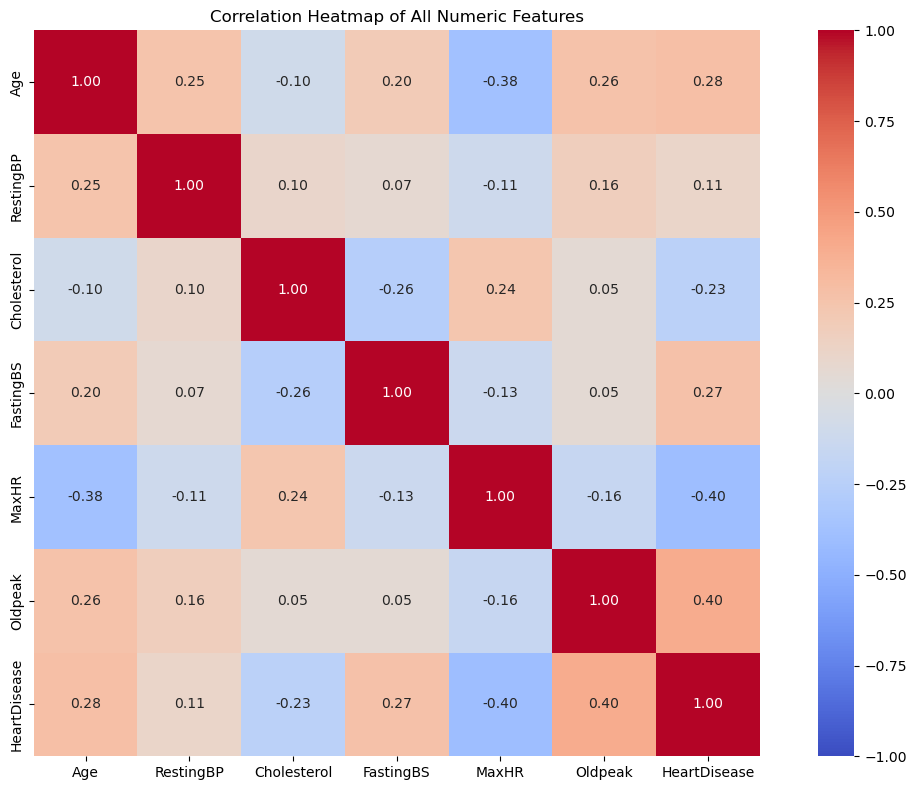

In [58]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f", 
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True
)

plt.title("Correlation Heatmap of All Numeric Features")
plt.tight_layout()
plt.show()

We are not dropping any features as all features seem to be relevant to predicting heart disease based on the EDA.

In [59]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [60]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [ ]:
# --- Start of code block copied from another author ---
# Title: Function to consolidate cross validation scores into a pandas series.
# Author: Varada Kolhatkar & Michael Gelbart
# Source: https://pages.github.ubc.ca/mds-2025-26/DSCI_571_sup-learn-1_students/README.html 
# Taken from: DSCI-571: Laboratory 2
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)
# --- End of code block copied from another author ---

In [62]:
numeric_transformer = StandardScaler()

In [63]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(drop='if_binary', handle_unknown="ignore", sparse_output=False), categorical_features),
)
preprocessor

,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [64]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

In [65]:
X_train = train_df.drop(columns=["HeartDisease"])
X_test = test_df.drop(columns=["HeartDisease"])
y_train = train_df["HeartDisease"]
y_test = test_df["HeartDisease"]

In [66]:
# Define Classification Metrics for scoring
classification_metrics = ["accuracy", "precision", "recall", "f1"]

## Models Evaluation

We decided to initiate our analysis considering a set of classification models including Decision Tree, kNN, SVM (with RBF kernel), Logistic Regression, and a dummy classifier as a baseline. 
All models were trained and evaluated using a 5-fold cross-validation strategy. The performance classification metrics used to evaluate the models were accuracy, precision, recall and F1-score.

Initially, the models were trained using default hyperparameters to define a model that would be further optimized in subsequent steps for this project.

The configuration and results of the cross-validations are detailed below:

In [67]:
# Define models to evaluate
models = {
    "dummy": DummyClassifier(random_state=123),
    "decision_tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=123),
    #"naive_bayes": MultinomialNB(),
    "logistic_regression": LogisticRegression(random_state=123, max_iter=1000)
}

In [68]:
# Build pipeline function
def build_pipe(model):
    return make_pipeline(preprocessor, model)

In [ ]:
# Execute cross-validation for each model and store results
results_dict = {}

for estimator in models:
    results_dict[estimator] = mean_std_cross_val_scores(
        build_pipe(models[estimator]),
        X_train,
        y_train,
        cv=5,
        return_train_score=True,
        scoring=classification_metrics
    )
    results_df = pd.DataFrame(results_dict)

results_df

,dummy,decision_tree,kNN,SVM,logistic_regression
fit_time,0.004 (+/- 0.002),0.003 (+/- 0.000),0.002 (+/- 0.000),0.004 (+/- 0.000),0.004 (+/- 0.001)
score_time,0.005 (+/- 0.003),0.003 (+/- 0.000),0.004 (+/- 0.000),0.004 (+/- 0.000),0.005 (+/- 0.002)
test_accuracy,0.548 (+/- 0.002),0.773 (+/- 0.020),0.844 (+/- 0.045),0.860 (+/- 0.026),0.864 (+/- 0.031)
train_accuracy,0.548 (+/- 0.000),1.000 (+/- 0.000),0.893 (+/- 0.006),0.906 (+/- 0.008),0.870 (+/- 0.008)
test_precision,0.548 (+/- 0.002),0.803 (+/- 0.014),0.853 (+/- 0.028),0.860 (+/- 0.018),0.859 (+/- 0.018)
train_precision,0.548 (+/- 0.000),1.000 (+/- 0.000),0.895 (+/- 0.007),0.907 (+/- 0.010),0.872 (+/- 0.008)
test_recall,1.000 (+/- 0.000),0.776 (+/- 0.052),0.864 (+/- 0.067),0.889 (+/- 0.057),0.900 (+/- 0.057)
train_recall,1.000 (+/- 0.000),1.000 (+/- 0.000),0.912 (+/- 0.006),0.923 (+/- 0.011),0.893 (+/- 0.009)
test_f1,0.708 (+/- 0.002),0.788 (+/- 0.025),0.858 (+/- 0.045),0.874 (+/- 0.028),0.879 (+/- 0.032)
train_f1,0.708 (+/- 0.000),1.000 (+/- 0.000),0.904 (+/- 0.006),0.915 (+/- 0.007),0.882 (+/- 0.007)


_Table 1. Cross-validation 5-folds results for all models._

After performing the cross-validation, we observed that both the Logistic Regression and SVM models had the best performance across all metrics, with Logistic Regression slightly outperforming SVM all-around. 

Based on this, we decided to choose the Logistic Regression model as our final model for predicting heart disease risk. 

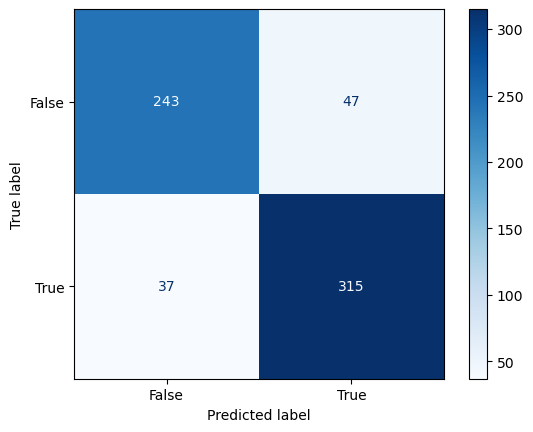

In [ ]:
# Confusion Matrix for Logistic Regression
lr_pipe = make_pipeline(preprocessor, 
                        LogisticRegression(random_state=123, max_iter=1000))

conf_mat_logreg = ConfusionMatrixDisplay.from_estimator(
    #build_pipe["logistic_regression"].fit(X_train, y_train),
    lr_pipe.fit(X_train, y_train),
    X_train,
    y_train,
    values_format="d",
    cmap='Blues'
)
conf_mat_logreg


_Figure 1. Confusion matrix for Logistic Regression model - Train set._

## Evaluation on Test Set

In [74]:
# Evaluate on Test Set
# Classification report

y_pred = lr_pipe.predict(X_test)

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)


              precision    recall  f1-score   support

       False       0.89      0.81      0.85       120
        True       0.86      0.92      0.89       156

    accuracy                           0.87       276
   macro avg       0.88      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



_Table 2. Classification Report for Test Set._

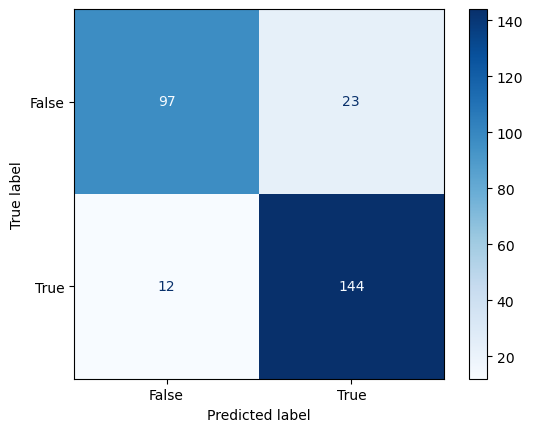

In [ ]:
# Confusion Matrix for Logistic Regression model on Test Set

conf_mat_logreg = ConfusionMatrixDisplay.from_estimator(
    lr_pipe.fit(X_test, y_test),
    X_test,
    y_test,
    values_format="d",
    cmap='Blues'
)
conf_mat_logreg

_Figure 2. Confusion matrix for Logistic Regression model - Test set._

The initial results of the Logistic Regression prediction model on the test set showed good performance across all metrics, as detailed in Table 2. This matched our expectations based on the cross-validation results, indicating that the model would generalize well on unseen data. This is already a positive outcome for a first iteration of the model and provides a solid foundation for further improvements. It also has the potential to be useful as a support tool for clinical screening of patients.

Aside from the hyperparameter tuning that will be explored on future stages, this use case is well suited for Precision-Recall and Receiver Operating Characteristic (ROC) curve analysis to further evaluate the model's threshold settings and trade-offs between precision and recall. This is a medical-related application, and it is crucial to minimize false negatives i.e., predicting a patient is not at risk when they actually are. Also, making the probability scores available for the predictions could increase the model's utility, supporting the decision-making of healthcare professionals. 

Finally, we could review the features coefficients from the Logistic Regression model to understand their influence on the predictions, enabling to better interpret the model's decisions and confirm if we could drop any features in future iterations.

# References